In [1]:
import warnings
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import itertools
init_notebook_mode(connected=True)
sys.path.append("C:/dev/pycmqlib3/")
sys.path.append("C:/dev/pycmqlib3/misc_scripts/")
warnings.filterwarnings('ignore')
import misc
import data_handler as dh
import plotly_examples
import backtest
import alphalens as al
%matplotlib inline

In [2]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc'] #, 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'CY', 'SR', 'jd', 'AP'] #, 'sp', 'CJ', 'UR']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts
sim_start_dict = { 'c': datetime.date(2008,10,1), 'm': datetime.date(2010,10,1),
    'y': datetime.date(2010,1,1), 'l': datetime.date(2008,1,1), 'rb':datetime.date(2010,1,1),
    'p': datetime.date(2010,1,1), 'cu':datetime.date(2010,1,1), 'al':datetime.date(2010,1,1),
    'zn':datetime.date(2010,1,1), 'au':datetime.date(2010,1,1), 'v': datetime.date(2010,1,1),
    'a': datetime.date(2010,1,1), 'ru':datetime.date(2010,1,1), 'ag':datetime.date(2012,7,6),
    'i': datetime.date(2013,12,13), 'j': datetime.date(2011,6,14), 'jm':datetime.date(2013,5,24),
    'CF':datetime.date(2008,1,1),  'TA':datetime.date(2007,2,15),
    'PM':datetime.date(2012,10,1), 'RM':datetime.date(2013,3,16),  'SR':datetime.date(2006,1,6),
    'FG':datetime.date(2013,2,1),  'OI':datetime.date(2013,6,1),  'RI':datetime.date(2013,6,1),
    'WH':datetime.date(2014,2,1),  'pp':datetime.date(2014,4,28),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2011,12,23),  'TF':datetime.date(2014,4,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,17),
    'jd':datetime.date(2014,1,6),  'ni':datetime.date(2015,5,26),  'sn':datetime.date(2015,6,8),
    'ZC':datetime.date(2013,12,28), 'hc':datetime.date(2014, 5, 21), 'SM': datetime.date(2016,11,21),
    'SF': datetime.date(2017,5,17), 'CY': datetime.date(2017, 7, 17), 'AP': datetime.date(2018, 2, 26),
    'TS': datetime.date(2018, 8, 17), 'fu': datetime.date(2018, 7, 16), 'sc': datetime.date(2018, 5, 25),
    'b': datetime.date(2017, 12, 26), 'pb': datetime.date(2011, 5, 24), 'bu': datetime.date(2015,11,1),
    'T':datetime.date(2015,6,1), 'ss': datetime.date(2020, 4, 1), 'sp': datetime.date(2019, 1, 24),
    'CJ': datetime.date(2019, 8, 1), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2019, 12, 9),
    'eb': datetime.date(2019, 12, 1), 'eg': datetime.date(2019, 2, 13), 'rr': datetime.date(2019, 8, 19),
    'pg': datetime.date(2020, 10, 1), 'lu': datetime.date(2020, 8, 1),}

In [6]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']

start_date = datetime.date(2010,1,1)
end_date = datetime.date(2020,12,23)
pnl_tenors = ['1y', '2y', '3y', '4y', '5y', '6y', '8y', '10y']

sim_products = commod_all_mkts
need_shift = 1
freq = 'd'
delim = '-'
dbtbl_prefix = ''
args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}
sc_args = {'n': 1, 'roll_rule': '-20b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}
eq_args = {'n': 1, 'roll_rule': '-1b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}
bond_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}
precious_args = {'n': 1, 'roll_rule': '-25b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': dbtbl_prefix}

df_list = []
for idx, asset in enumerate(sim_products):
    use_args = args
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb', 'sn']:
        use_args = base_args
    elif asset in ['sc']:
        use_args = sc_args  
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(sim_start_dict[asset], start_date)
    use_args['end_date'] = end_date
    print("loading mkt = %s, args = %s" % (asset, use_args))
    df = misc.nearby(asset, **use_args)
    if freq == 'm':
        df = misc.cleanup_mindata(df, asset)
    if (idx == 0) and (freq == 'm'):
        df_list.append(df[['date', 'min_id']])
    xdf = df[field_list]
    xdf.columns = [delim.join((asset, col)) for col in xdf.columns]
    df_list.append(xdf)

df = pd.concat(df_list, axis = 1, sort = False).sort_index()
print(df.tail(20))

loading mkt = rb, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2010, 1, 1), 'end_date': datetime.date(2020, 12, 23)}
loading mkt = hc, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2014, 5, 21), 'end_date': datetime.date(2020, 12, 23)}
loading mkt = i, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2013, 12, 13), 'end_date': datetime.date(2020, 12, 23)}
loading mkt = j, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2011, 6, 14), 'end_date': datetime.date(2020, 12, 23)}
loading mkt = jm, args = {'n': 1, 'roll_rule': '-30b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': '', 'start_date': datetime.date(2013, 5, 24), 'end_date': datetime.date(2020, 12, 23)}
loading mkt = ru, args = {'n': 1, 'roll_rule': '-30b', 'freq':

In [7]:
def run_xs_test(input_args):
    product_list = input_args['product_list']
    mom_win = input_args['win']
    ma_win = input_args['ma_win']
    vol_win = input_args['std_win']
    pos_std = input_args['pos_std']
    rebal_freq = input_args['rebal_freq']
    cost_ratio = input_args.get('cost_ratio', 0.5)
    quantile_cutoff = input_args.get('quantile', 0.2)
    run_mode = input_args.get('run_mode', "momma")
    params = input_args.get('params', [0.2])
    prefix = input_args.get('prefix', "")
    run_name = input_args.get('run_name', 'test')
    start_date = input_args.get('start_date', None)
    end_date = input_args.get('end_date', None)
    select_cols = []
    rank_field = ""
    for col in df.columns:
        col_split = col.split(delim)
        if col_split[0] in product_list:
            select_cols.append(col)
    xdf= df[select_cols].sort_index().fillna(method='ffill').copy()
    if start_date:
        xdf = xdf[xdf.index>= start_date]
    if end_date:
        xdf = xdf[xdf.index<= end_date]
        
    for asset in product_list:
        if need_shift == 1:
            xdf[delim.join((asset, 'lr'))] = np.log(xdf[delim.join((asset, 'close'))] -xdf[delim.join((asset, 'shift'))])- np.log(xdf[delim.join((asset, 'close'))].shift(1) -xdf[delim.join((asset, 'shift'))])
        else:
            xdf[delim.join((asset, 'lr'))] = \
                np.log(xdf[delim.join((asset, 'close'))])- np.log(xdf[delim.join((asset, 'close'))].shift(1))
        if run_mode == 'mom':
            xdf[delim.join((asset, 'mom'))] =  xdf[delim.join((asset, 'lr'))].rolling(mom_win).sum()
            rank_field = "mom"
        if run_mode == 'momma':
            xdf[delim.join((asset, 'momma'))] =  xdf[delim.join((asset, 'lr'))].rolling(mom_win).sum().rolling(ma_win).mean()
            rank_field = "momma"
        elif run_mode == 'rsima':
            rsi_output = dh.RSI_F(xdf, mom_win, prefix = asset + delim)
            xdf[delim.join((asset, 'rsi'))] = rsi_output[asset + delim + 'RSI' + str(mom_win)]
            xdf[delim.join((asset, 'rsima'))] = dh.EMA(xdf, ma_win, field = 'rsi', prefix = asset + delim)
            rank_field = "rsima"
        elif run_mode == 'madist':
            xdf[delim.join((asset, 'ema1'))] = dh.EMA(xdf, mom_win, field = 'close', prefix = asset + delim)
            xdf[delim.join((asset, 'ema2'))] = dh.EMA(xdf, int(mom_win * params[0]), field = 'close', prefix = asset + delim)
            xdf[delim.join((asset, 'std'))] = dh.STDEV(xdf, ma_win, field = 'close', prefix = asset + delim)
            xdf[delim.join((asset, 'madist'))] = (xdf[delim.join((asset, 'ema1'))] - xdf[delim.join((asset, 'ema2'))])/xdf[delim.join((asset, 'std'))]
            xdf[delim.join((asset, 'nmadist'))] = xdf[delim.join((asset, 'madist'))]/dh.STDEV(xdf, int(ma_win * params[1]), field = 'madist', prefix = asset + delim)
            xdf[delim.join((asset, 'sig'))] = xdf[delim.join((asset, 'nmadist'))].apply(lambda x: dh.response_curve(x, "absorbing", param = 2.0))
            rank_field = "sig"
        if need_shift == 1:        
            orig_close = xdf[delim.join((asset, 'close'))] -xdf[delim.join((asset, 'shift'))]
            if pos_std == 1:
                xdf[delim.join((asset, 'std'))] = dh.ATR(df, vol_win, prefix = asset + delim).fillna(method='bfill') * 10.0
            else:
                xdf[delim.join((asset, 'std'))] = orig_close
        elif need_shift == 2:
            orig_close = xdf[delim.join((asset, 'close'))] * np.exp(-xdf[delim.join((asset, 'shift'))])
            if pos_std == 1:
                xdf[delim.join((asset, 'std'))] = (np.log(xdf[delim.join((asset, 'close'))]) \
                                - np.log(xdf[delim.join((asset, 'close'))].shift(1))).rolling(vol_win).std() \
                                * orig_close * 10
            else:
                xdf[delim.join((asset, 'std'))] = orig_close
        else:
            orig_close = xdf[delim.join((asset, 'close'))]
            xdf[delim.join((asset, 'std'))] = orig_close
        
    total_risk = 5000000.0
    margin_rate = [0.08, 0.08]
    offset_list = [ backtest.trade_offset_dict.get(asset, 0.0) for asset in product_list]
    offset_list = [ offset * cost_ratio for offset in offset_list]
    start_capital = 0.0

    xdf['rebal_seqno'] = range(len(xdf.index))

    rank_df = xdf[[delim.join((asset, rank_field)) for asset in product_list]].rank(axis=1)
    rank_df.columns = product_list
    
    xdf['prod_count'] = rank_df.apply(lambda x: x.count() if x.count() > 0 else np.nan, axis=1).fillna(0)
    xdf['kcut'] = (xdf['prod_count'] * quantile_cutoff).astype('int')
    xdf['upper_rank'] = xdf['prod_count'] - xdf['kcut']
    xdf['lower_rank'] = xdf['kcut'] + 1 
    
    long_pos = pd.DataFrame(0, columns = product_list, index = xdf.index)
    short_pos = pd.DataFrame(0, columns = product_list, index = xdf.index)

    for rebal_idx in range(rebal_freq):
        long_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
        short_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
        rebal_flag = xdf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx)
        for asset in product_list:
            long_tmp.loc[(rank_df[asset]>xdf['upper_rank']) & rebal_flag, asset] = 1.0
            long_tmp.loc[(rank_df[asset]<=xdf['upper_rank']) & rebal_flag, asset] = 0.0
            short_tmp.loc[(rank_df[asset]<xdf['lower_rank']) & rebal_flag, asset] = 1.0
            short_tmp.loc[(rank_df[asset]>=xdf['lower_rank']) & rebal_flag, asset] = 0.0
        long_tmp = long_tmp.fillna(method='ffill').fillna(0)
        short_tmp = short_tmp.fillna(method='ffill').fillna(0)
        long_sum = long_tmp.sum(axis=1)
        short_sum = short_tmp.sum(axis=1)
        long_pos = long_pos + long_tmp.div(long_sum,axis=0)
        short_pos = short_pos + short_tmp.div(short_sum,axis=0)
    extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
    df_list = []

    for asset, offset in zip(product_list, offset_list):
        long_pos[asset] = (long_pos[asset] * total_risk / rebal_freq \
                    /xdf[delim.join((asset,'std'))].astype('float')).shift(1).fillna(method='ffill') 
        short_pos[asset] = (short_pos[asset] * total_risk / rebal_freq \
                    /xdf[delim.join((asset,'std'))].astype('float')).shift(1).fillna(method='ffill')
        xdf[delim.join((asset, 'pos'))] = long_pos[asset].fillna(0.0) - short_pos[asset].fillna(0.0)
        xdf[delim.join((asset, 'traded_price'))] = xdf[delim.join((asset, 'open'))]
        xdf[delim.join((asset, 'pos'))].iloc[-1] = 0
        xdf[delim.join((asset, 'cost'))] = \
                abs(xdf[delim.join((asset, 'pos'))] \
                - xdf[delim.join((asset, 'pos'))].shift(1)) * offset
        xdf[delim.join((asset, 'cost'))] = xdf[delim.join((asset, 'cost'))].fillna(0.0)
        fields = [delim.join((asset, field)) for field in extract_fields] 
        tdf = xdf[fields]
        tdf.columns = extract_fields
        tdf.index.name = 'date'    
        if freq == 'm':
            tdf['date'] = xdf['date']
            tdf['min_id'] = xdf['min_id']
        #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)
        df_list.append(tdf)
    (res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, freq, tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
    pos_df = xdf[[delim.join((asset, 'pos')) for asset in product_list]]
    cum_pnl = ts['cum_pnl']
    cum_pnl.name = run_name
    pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
    pnl_df.columns = [run_name]
    res = {'cum_pnl': ts['cum_pnl'], 'name': run_name, 'pnl_stats': pnl_df, 'pos_df': pos_df}
    return res

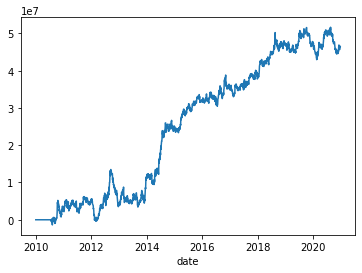

                 mom-mixed_metal_mkts-130-1-5
sharp_ratio_10y                      0.724621
sharp_ratio_1y                      -0.036100
sharp_ratio_2y                      -0.034768
sharp_ratio_3y                       0.457008
sharp_ratio_4y                       0.475557
sharp_ratio_5y                       0.527150
sharp_ratio_6y                       0.678848
sharp_ratio_8y                       0.908117
std_pnl_10y                     389936.041766
std_pnl_1y                      366280.532264
std_pnl_2y                      352569.275605
std_pnl_3y                      363133.424303
std_pnl_4y                      357196.114190
std_pnl_5y                      365543.854323
std_pnl_6y                      356100.995219
std_pnl_8y                      384832.538358


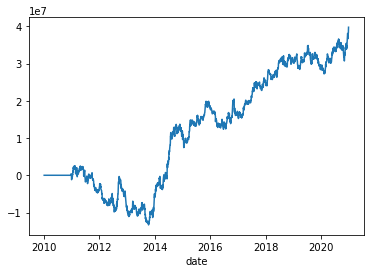

                 mom-mixed_metal_mkts-230-1-5
sharp_ratio_10y                      0.656311
sharp_ratio_1y                       1.709315
sharp_ratio_2y                       0.770737
sharp_ratio_3y                       0.856025
sharp_ratio_4y                       1.015938
sharp_ratio_5y                       0.757476
sharp_ratio_6y                       0.846043
sharp_ratio_8y                       1.007536
std_pnl_10y                     395479.178160
std_pnl_1y                      418869.168278
std_pnl_2y                      388512.534366
std_pnl_3y                      376165.595003
std_pnl_4y                      365391.328918
std_pnl_5y                      371052.661505
std_pnl_6y                      369496.042678
std_pnl_8y                      391943.295572


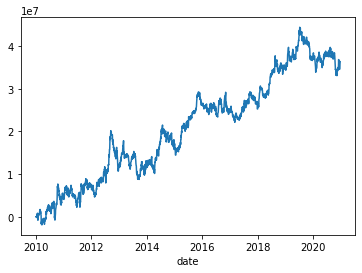

                 rsima-mixed_metal_mkts-60-80-5
sharp_ratio_10y                        0.502343
sharp_ratio_1y                        -0.160962
sharp_ratio_2y                         0.124728
sharp_ratio_3y                         0.546293
sharp_ratio_4y                         0.482536
sharp_ratio_5y                         0.349329
sharp_ratio_6y                         0.556513
sharp_ratio_8y                         0.537622
std_pnl_10y                       405880.986108
std_pnl_1y                        423601.956145
std_pnl_2y                        408647.165240
std_pnl_3y                        393512.644462
std_pnl_4y                        377338.742865
std_pnl_5y                        380789.626681
std_pnl_6y                        379635.867372
std_pnl_8y                        389898.785479


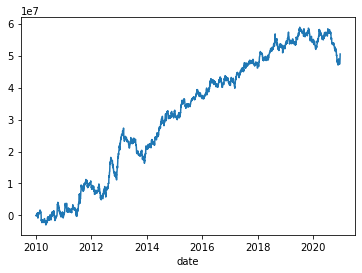

                 rsima-mixed_metal_mkts-10-80-5
sharp_ratio_10y                        0.799213
sharp_ratio_1y                        -0.614678
sharp_ratio_2y                        -0.168846
sharp_ratio_3y                         0.173900
sharp_ratio_4y                         0.376549
sharp_ratio_5y                         0.463082
sharp_ratio_6y                         0.569398
sharp_ratio_8y                         0.691055
std_pnl_10y                       405391.093007
std_pnl_1y                        421986.570347
std_pnl_2y                        401887.128621
std_pnl_3y                        396057.624320
std_pnl_4y                        381596.742992
std_pnl_5y                        379598.227347
std_pnl_6y                        371284.790020
std_pnl_8y                        382120.768837


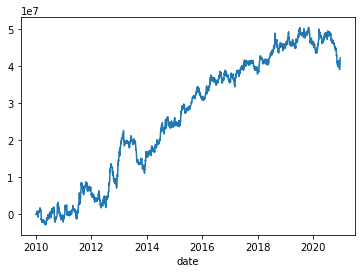

                 rsima-mixed_metal_mkts-40-20-5
sharp_ratio_10y                        0.690265
sharp_ratio_1y                        -0.619366
sharp_ratio_2y                        -0.245832
sharp_ratio_3y                         0.170938
sharp_ratio_4y                         0.250720
sharp_ratio_5y                         0.375297
sharp_ratio_6y                         0.536555
sharp_ratio_8y                         0.617592
std_pnl_10y                       402861.809316
std_pnl_1y                        415840.105934
std_pnl_2y                        397333.035884
std_pnl_3y                        393491.578306
std_pnl_4y                        380358.510837
std_pnl_5y                        378306.709609
std_pnl_6y                        370221.217273
std_pnl_8y                        381158.953329


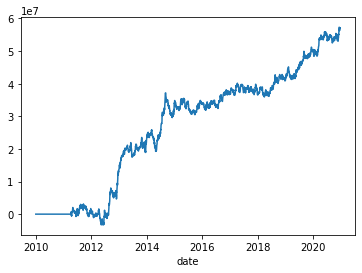

                 madist-mixed_metal_mkts-16-100-5
sharp_ratio_10y                          0.983218
sharp_ratio_1y                           1.166291
sharp_ratio_2y                           1.415574
sharp_ratio_3y                           1.161046
sharp_ratio_4y                           0.942222
sharp_ratio_5y                           0.863628
sharp_ratio_6y                           0.782484
sharp_ratio_8y                           0.976981
std_pnl_10y                         379604.251069
std_pnl_1y                          385517.851385
std_pnl_2y                          365520.527973
std_pnl_3y                          357574.544871
std_pnl_4y                          349714.845659
std_pnl_5y                          349509.637139
std_pnl_6y                          354098.335259
std_pnl_8y                          375702.058721


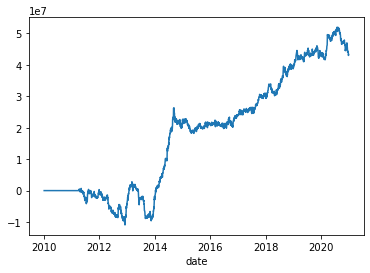

                 madist-mixed_metal_mkts-40-100-5
sharp_ratio_10y                          0.745553
sharp_ratio_1y                          -0.026313
sharp_ratio_2y                           0.335830
sharp_ratio_3y                           0.752011
sharp_ratio_4y                           0.872779
sharp_ratio_5y                           0.799878
sharp_ratio_6y                           0.710306
sharp_ratio_8y                           1.035775
std_pnl_10y                         378345.045180
std_pnl_1y                          394562.309957
std_pnl_2y                          377192.629333
std_pnl_3y                          374781.798766
std_pnl_4y                          355330.336436
std_pnl_5y                          355210.269381
std_pnl_6y                          351947.309367
std_pnl_8y                          383171.288044


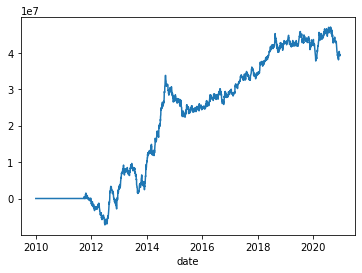

                 madist-mixed_metal_mkts-56-140-5
sharp_ratio_10y                          0.685904
sharp_ratio_1y                          -0.500736
sharp_ratio_2y                          -0.276861
sharp_ratio_3y                           0.309745
sharp_ratio_4y                           0.492425
sharp_ratio_5y                           0.502127
sharp_ratio_6y                           0.365133
sharp_ratio_8y                           0.790193
std_pnl_10y                         375185.841071
std_pnl_1y                          421514.293113
std_pnl_2y                          394236.275629
std_pnl_3y                          374837.411079
std_pnl_4y                          355761.112013
std_pnl_5y                          358211.953647
std_pnl_6y                          368365.865033
std_pnl_8y                          392095.926123
                 rb-pos       hc-pos        i-pos         j-pos       jm-pos  \
date                                                                  

In [10]:
res = {}
stats_list = []
cum_list = []
sratio_years = [int(ten[:-1]) for ten in pnl_tenors]

mixed_metal_mkts = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'ni']
commod_mkts = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'ZC', 'cu', 'al', 'zn', 'pb', 'ni', 'sn', \
               'l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'CF', 'SR', 'jd'] 

product_list =  mixed_metal_mkts 
#commod_mkts #ind_all_mkts + ags_all_mkts # ind_metal_mkts # commod_all_mkts #  ferrous_products_mkts # 
product_name = 'mixed_metal_mkts'
run_mode = 'madist'
start_date = datetime.date(2010,1,1)
end_date = datetime.date(2020,12,23)

pos_std = 1
std_win = 20
ma_win = 120
rebal = 5
quantile = 0.2
#save_loc = "C:\\dev\\data\\selected_xsmom_%s_" % ('_'.join([run_mode, product_name, str(quantile), str(end_date)]))
save_loc = "C:\\dev\\data\\combined_xsmom_%s_" % ('_'.join([product_name, str(quantile), str(end_date)]))

index_list = range(8, 88, 8) #range(10, 110, 10) #range(10, 250, 10) #  
column_list = [60, 80, 100, 120, 140, 160] #range(10, 90, 10) #range(10, 130, 10) #[1, 3, 5, 10, 15, 20] #[i * 0.01 for i in range(0, 32, 4)] # 
sratio = {}
run_sratio = False
run_pos_sum = True

pos_sum = pd.DataFrame()
pos_list = []
#scenarios = list(itertools.product(index_list, column_list))
#mixed_metal_mkts
scenarios = [('mom', 130, 1, 5, [0.0]), ('mom', 230, 1, 5, [0.0]),\
             ('rsima', 60, 80, 5, [0.0]), ('rsima', 10, 80, 5, [0.0]), ('rsima', 40, 20, 5, [0.0]),\
             ('madist', 16, 100, 5, [1.5, 2.0]), ('madist', 40, 100, 5, [1.5, 2.0]), ('madist', 56, 140, 5, [1.5, 2.0])]
#commod_all_mkts
#scenarios = [('mom', 20, 1, 5, [0.0]), ('mom', 210, 1, 5, [0.0]), #('mom', 160, 1, 5, [0.0]),
#             ('momma', 140, 120, 5, [0.0]), ('momma', 240, 120, 5, [0.0]), \
#             ('rsima', 70, 60, 5, [0.0]), ('rsima', 100, 80, 5, [0.0]), ('rsima', 90, 10, 5, [0.0]), \
#             ('madist', 8, 100, 5, [1.5, 2.0]), ('madist', 16, 100, 5, [1.5, 2.0]), ('madist', 32, 100, 5, [1.5, 2.0]), #('madist', 64, 100, 5, [1.5, 2.0]), 
#            ]
if run_sratio:
    for yr in sratio_years:
        sratio[yr] = pd.DataFrame(0, index = index_list, columns = column_list)
        
for scen in scenarios: 
    if len(scen) == 2:
        scen_x = scen[0]
        scen_y = scen[1]
        if run_mode in ['mom']:
            win = scen_x
            ma_win = 1
            rebal = scen_y
            params = [0.0]
        elif run_mode in ['momma', 'rsima', 'madist']:
            win = scen_x
            ma_win = scen_y
            rebal = 5
            params = [1.5, 2.0]
        else:
            print("unsupported run_mode")
            continue
    elif len(scen) == 5:
        run_mode = scen[0]
        win = scen[1]
        ma_win = scen[2]
        rebal = scen[3]
        params = scen[4]
    else:
        print("unsupported scenarios")
        continue
    run_args = {}
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date
    run_args['cost_ratio'] = 0.5
    run_args['product_list'] = product_list
    run_args['run_name'] = run_name = '-'.join([run_mode, product_name, str(win), str(ma_win), str(rebal)])  
    run_args['win'] = win
    run_args['ma_win'] = ma_win
    run_args['std_win'] = std_win
    run_args['prefix'] = save_loc        
    run_args['rebal_freq'] = rebal
    run_args['pos_std'] = pos_std
    run_args['params'] = params
    run_args['quantile'] = quantile
    run_args['run_mode'] = run_mode
    res = run_xs_test(run_args)
    res['cum_pnl'].plot()
    plt.show()
    cum_list.append(res['cum_pnl'])
    stats_list.append(res['pnl_stats'])
    vdf = res['pnl_stats']
    vdf = vdf.loc[[idx for idx in vdf.index if ('sharp' in idx) or ('std' in idx)], :]
    print(vdf)
    if run_pos_sum:
        pos_list.append(res['pos_df'])
        pos_sum = pos_sum.add(res['pos_df'], fill_value = 0)  
    if run_sratio:
        for yr in sratio_years:
            lbl = 'sharp_ratio_' + str(yr) + 'y'
            sratio[yr][scen_y].loc[scen_x] = res['pnl_stats'][run_name][lbl]
        

cum_df = pd.concat(cum_list, axis = 1)
cum_df.to_csv(save_loc + 'pnl.csv')
stats_df = pd.concat(stats_list, axis = 1)
stats_df.T.to_csv(save_loc + 'stats.csv')
if run_pos_sum:
    print(pos_sum)
if run_sratio:
    for yr in sratio_years:
        print(sratio[yr])


In [7]:
save_xl = True
if run_pos_sum and save_xl:
    xlfile = save_loc + "pos_data.xlsx"
    writer = pd.ExcelWriter(xlfile)
    for idx in range(len(pos_list)):            
        pos_list[idx].to_excel(writer, str(idx), startcol= 0, startrow=1)
    pos_sum.to_excel(writer, "sum", startcol= 0, startrow=1)
    writer.save()    
if run_sratio and save_xl:
    xlfile = save_loc + "sratio_heatmap.xlsx"
    writer = pd.ExcelWriter(xlfile)
    for yr in sratio_years:
        lbl = 'sharp_ratio_' + str(yr) + 'y'
        sratio[yr].to_excel(writer, lbl, startcol= 0, startrow=1)
    writer.save()    